In [1]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats

In [2]:
def retrieveCfbData(endpoint, team, year, week):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType=regular&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [3]:
# init data retrieval
teams = pd.read_csv("data/teams/2018.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2017, 2019):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys)

In [4]:
print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

# print(f"2016 Drives: {len(base_drives[base_drives.game_id == 400868979])}")
# base_drives[base_drives.offense == 'Ole Miss']

Total Games: 1679
Total Drives: 43173
Total Plays: 304691


In [5]:
# Data cleaning
base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
# base_drives.drop(['offense_conference','start_time','end_time','defense_conference','elapsed'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
pbp_data = pbp_data[
    (pbp_data.down != 0)
]

pbp_data.distance = pbp_data.distance.astype(float)

pbp_data.drop(['offense_conference','defense_conference'], axis = 1, inplace=True) 
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Defensive 2pt Conversion","Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Timeout","End of Half","End of Game","Uncategorized","Penalty","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Safety"]
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty"))]

bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types))
     & (~pbp_data.play_type.str.contains('Sack'))) ,['yards_gained']] = 0

Clean Drives: 29565


In [6]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate
    
def is_successful(down, distance, yards_gained, play_type):
    if (play_type in bad_types):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False

def is_explosive(yards_gained):
    if (yards_gained >= 15):
        return True
    else:
        return False
    
pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained)
pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [23]:
def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[pbp.offense == team]
    off_sr = calculate_success_rate(team_off_plays, [])
    off_er = calculate_exp_rate(team_off_plays, [])
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr]
    })

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to]
    })

def stringify_entry(team_entry):
    return team_entry.tolist()[0]

def calculate_five_factors_rating(team_stat_pack):
    return (.35 * team_stat_pack.OffSR) + (.25 * (team_stat_pack.OffER * team_stat_pack.YPP)) + (.15 * (team_stat_pack.FP / 50.0)) + (.15 * ((team_stat_pack.PPD + team_stat_pack.OppSR + team_stat_pack.OppEff)/3)) + (.10 * team_stat_pack.ExpTODiff)

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    
    game_drives = drives[drives.game_id == game_id]
    if (len(game_drives) == 0):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week))
        if (len(game_drives) == 0):
            print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
            return None
        else:
            game_drives.rename(columns={"id": "drive_id"}, inplace=True)
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    game_pbp['play_explosive'] = np.vectorize(is_explosive)(game_pbp.yards_gained)
    game_pbp['play_successful'] = np.vectorize(is_successful)(game_pbp.down, game_pbp.distance, game_pbp.yards_gained, game_pbp.play_type)
    
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')
    
    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    home_team_stats['ExpTODiff'] = home_team_stats['ExpTO'] - away_team_stats['ExpTO']
    away_team_stats['ExpTODiff'] = away_team_stats['ExpTO'] - home_team_stats['ExpTO']
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
calculate_box_score(401013183, 2018)

/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff
0,Virginia,31,-3,0.875665,0.381818,0.072727,4.927273,28.1,3.1,0.75,0.4,0.515152,1.15,0.22,0.547781,0.011873
1,Virginia Tech,34,3,0.124335,0.403226,0.080645,5.629032,26.3,3.4,0.60,0.5,0.487805,0.93,-0.22,0.535908,-0.011873


In [8]:
stored_game_boxes = pd.DataFrame()
game_ids = games.id.unique()
team_list = teams.school.tolist()
for i, row in games.iterrows():
    gameId = row.id
    print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}")
    print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}")
    if ((row.home_team in team_list) & (row.away_team in team_list)):
        box_score = calculate_box_score(gameId, row.season)
        if (box_score is not None):
            game_tms = box_score.Team.tolist()
            print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}")
            stored_game_boxes = stored_game_boxes.append(box_score)
            print(f"[{i+1}/{len(game_ids)}] Aggreggating game_id {gameId} to master data copy")
        else:
            print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing")
    else:
        print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS")

[1/1679] Getting game information for ESPN game_id: 400935282
[1/1679] Started processing game information for ESPN game_id: 400935282
[1/1679] Completed processing game information for ESPN game_id: 400935282
[1/1679] Aggreggating game_id 400935282 to master data copy
[2/1679] Getting game information for ESPN game_id: 400945031
[2/1679] Started processing game information for ESPN game_id: 400945031
[2/1679] Skipping checking game_id 400945031 bc one of the teams isn't FBS
[3/1679] Getting game information for ESPN game_id: 400938887
[3/1679] Started processing game information for ESPN game_id: 400938887
[3/1679] Completed processing game information for ESPN game_id: 400938887
[3/1679] Aggreggating game_id 400938887 to master data copy
[4/1679] Getting game information for ESPN game_id: 400941786
[4/1679] Started processing game information for ESPN game_id: 400941786
[4/1679] Completed processing game information for ESPN game_id: 400941786
[4/1679] Aggreggating game_id 400941786 

[41/1679] Completed processing game information for ESPN game_id: 400933837
[41/1679] Aggreggating game_id 400933837 to master data copy
[42/1679] Getting game information for ESPN game_id: 400935236
[42/1679] Started processing game information for ESPN game_id: 400935236
[42/1679] Completed processing game information for ESPN game_id: 400935236
[42/1679] Aggreggating game_id 400935236 to master data copy
[43/1679] Getting game information for ESPN game_id: 400933830
[43/1679] Started processing game information for ESPN game_id: 400933830
[43/1679] Completed processing game information for ESPN game_id: 400933830
[43/1679] Aggreggating game_id 400933830 to master data copy
[44/1679] Getting game information for ESPN game_id: 400934492
[44/1679] Started processing game information for ESPN game_id: 400934492
[44/1679] Completed processing game information for ESPN game_id: 400934492
[44/1679] Aggreggating game_id 400934492 to master data copy
[45/1679] Getting game information for ES

[77/1679] Completed processing game information for ESPN game_id: 400935235
[77/1679] Aggreggating game_id 400935235 to master data copy
[78/1679] Getting game information for ESPN game_id: 400934494
[78/1679] Started processing game information for ESPN game_id: 400934494
[78/1679] Skipping checking game_id 400934494 bc one of the teams isn't FBS
[79/1679] Getting game information for ESPN game_id: 400933839
[79/1679] Started processing game information for ESPN game_id: 400933839
[79/1679] Completed processing game information for ESPN game_id: 400933839
[79/1679] Aggreggating game_id 400933839 to master data copy
[80/1679] Getting game information for ESPN game_id: 400941793
[80/1679] Started processing game information for ESPN game_id: 400941793
[80/1679] Skipping checking game_id 400941793 bc one of the teams isn't FBS
[81/1679] Getting game information for ESPN game_id: 400935253
[81/1679] Started processing game information for ESPN game_id: 400935253
[81/1679] Skipping checkin

[110/1679] Completed processing game information for ESPN game_id: 400938605
[110/1679] Aggreggating game_id 400938605 to master data copy
[111/1679] Getting game information for ESPN game_id: 400944894
[111/1679] Started processing game information for ESPN game_id: 400944894
[111/1679] Skipping checking game_id 400944894 bc one of the teams isn't FBS
[112/1679] Getting game information for ESPN game_id: 400944895
[112/1679] Started processing game information for ESPN game_id: 400944895
[112/1679] Skipping checking game_id 400944895 bc one of the teams isn't FBS
[113/1679] Getting game information for ESPN game_id: 400944896
[113/1679] Started processing game information for ESPN game_id: 400944896
[113/1679] Skipping checking game_id 400944896 bc one of the teams isn't FBS
[114/1679] Getting game information for ESPN game_id: 400937459
[114/1679] Started processing game information for ESPN game_id: 400937459
[114/1679] Completed processing game information for ESPN game_id: 4009374

[146/1679] Completed processing game information for ESPN game_id: 400933850
[146/1679] Aggreggating game_id 400933850 to master data copy
[147/1679] Getting game information for ESPN game_id: 400933843
[147/1679] Started processing game information for ESPN game_id: 400933843
[147/1679] Completed processing game information for ESPN game_id: 400933843
[147/1679] Aggreggating game_id 400933843 to master data copy
[148/1679] Getting game information for ESPN game_id: 400934502
[148/1679] Started processing game information for ESPN game_id: 400934502
[148/1679] Completed processing game information for ESPN game_id: 400934502
[148/1679] Aggreggating game_id 400934502 to master data copy
[149/1679] Getting game information for ESPN game_id: 400933847
[149/1679] Started processing game information for ESPN game_id: 400933847
[149/1679] Skipping checking game_id 400933847 bc one of the teams isn't FBS
[150/1679] Getting game information for ESPN game_id: 400933845
[150/1679] Started proces

[177/1679] Completed processing game information for ESPN game_id: 400934506
[177/1679] Aggreggating game_id 400934506 to master data copy
[178/1679] Getting game information for ESPN game_id: 400938612
[178/1679] Started processing game information for ESPN game_id: 400938612
[178/1679] Completed processing game information for ESPN game_id: 400938612
[178/1679] Aggreggating game_id 400938612 to master data copy
[179/1679] Getting game information for ESPN game_id: 400935271
[179/1679] Started processing game information for ESPN game_id: 400935271
[179/1679] Skipping checking game_id 400935271 bc one of the teams isn't FBS
[180/1679] Getting game information for ESPN game_id: 400944900
[180/1679] Started processing game information for ESPN game_id: 400944900
[180/1679] Skipping checking game_id 400944900 bc one of the teams isn't FBS
[181/1679] Getting game information for ESPN game_id: 400937469
[181/1679] Started processing game information for ESPN game_id: 400937469
[181/1679] C

[214/1679] Completed processing game information for ESPN game_id: 400935356
[214/1679] Aggreggating game_id 400935356 to master data copy
[215/1679] Getting game information for ESPN game_id: 400933861
[215/1679] Started processing game information for ESPN game_id: 400933861
[215/1679] Completed processing game information for ESPN game_id: 400933861
[215/1679] Aggreggating game_id 400933861 to master data copy
[216/1679] Getting game information for ESPN game_id: 400935355
[216/1679] Started processing game information for ESPN game_id: 400935355
[216/1679] Completed processing game information for ESPN game_id: 400935355
[216/1679] Aggreggating game_id 400935355 to master data copy
[217/1679] Getting game information for ESPN game_id: 400933863
[217/1679] Started processing game information for ESPN game_id: 400933863
[217/1679] Completed processing game information for ESPN game_id: 400933863
[217/1679] Aggreggating game_id 400933863 to master data copy
[218/1679] Getting game inf

[245/1679] Completed processing game information for ESPN game_id: 400937470
[245/1679] Aggreggating game_id 400937470 to master data copy
[246/1679] Getting game information for ESPN game_id: 400937475
[246/1679] Started processing game information for ESPN game_id: 400937475
[246/1679] Completed processing game information for ESPN game_id: 400937475
[246/1679] Aggreggating game_id 400937475 to master data copy
[247/1679] Getting game information for ESPN game_id: 400933871
[247/1679] Started processing game information for ESPN game_id: 400933871
[247/1679] Completed processing game information for ESPN game_id: 400933871
[247/1679] Aggreggating game_id 400933871 to master data copy
[248/1679] Getting game information for ESPN game_id: 400935359
[248/1679] Started processing game information for ESPN game_id: 400935359
[248/1679] Completed processing game information for ESPN game_id: 400935359
[248/1679] Aggreggating game_id 400935359 to master data copy
[249/1679] Getting game inf

[277/1679] Completed processing game information for ESPN game_id: 400945260
[277/1679] Aggreggating game_id 400945260 to master data copy
[278/1679] Getting game information for ESPN game_id: 400938620
[278/1679] Started processing game information for ESPN game_id: 400938620
[278/1679] Completed processing game information for ESPN game_id: 400938620
[278/1679] Aggreggating game_id 400938620 to master data copy
[279/1679] Getting game information for ESPN game_id: 400938619
[279/1679] Started processing game information for ESPN game_id: 400938619
[279/1679] Completed processing game information for ESPN game_id: 400938619
[279/1679] Aggreggating game_id 400938619 to master data copy
[280/1679] Getting game information for ESPN game_id: 400941805
[280/1679] Started processing game information for ESPN game_id: 400941805
[280/1679] Skipping checking game_id 400941805 bc one of the teams isn't FBS
[281/1679] Getting game information for ESPN game_id: 400934575
[281/1679] Started proces

[309/1679] Completed processing game information for ESPN game_id: 400935368
[309/1679] Aggreggating game_id 400935368 to master data copy
[310/1679] Getting game information for ESPN game_id: 400938890
[310/1679] Started processing game information for ESPN game_id: 400938890
[310/1679] Completed processing game information for ESPN game_id: 400938890
[310/1679] Aggreggating game_id 400938890 to master data copy
[311/1679] Getting game information for ESPN game_id: 400941809
[311/1679] Started processing game information for ESPN game_id: 400941809
[311/1679] Completed processing game information for ESPN game_id: 400941809
[311/1679] Aggreggating game_id 400941809 to master data copy
[312/1679] Getting game information for ESPN game_id: 400933876
[312/1679] Started processing game information for ESPN game_id: 400933876
[312/1679] Completed processing game information for ESPN game_id: 400933876
[312/1679] Aggreggating game_id 400933876 to master data copy
[313/1679] Getting game inf

[339/1679] Completed processing game information for ESPN game_id: 400935287
[339/1679] Aggreggating game_id 400935287 to master data copy
[340/1679] Getting game information for ESPN game_id: 400945264
[340/1679] Started processing game information for ESPN game_id: 400945264
[340/1679] Completed processing game information for ESPN game_id: 400945264
[340/1679] Aggreggating game_id 400945264 to master data copy
[341/1679] Getting game information for ESPN game_id: 400944846
[341/1679] Started processing game information for ESPN game_id: 400944846
[341/1679] Completed processing game information for ESPN game_id: 400944846
[341/1679] Aggreggating game_id 400944846 to master data copy
[342/1679] Getting game information for ESPN game_id: 400937487
[342/1679] Started processing game information for ESPN game_id: 400937487
[342/1679] Completed processing game information for ESPN game_id: 400937487
[342/1679] Aggreggating game_id 400937487 to master data copy
[343/1679] Getting game inf

[369/1679] Completed processing game information for ESPN game_id: 400944992
[369/1679] Aggreggating game_id 400944992 to master data copy
[370/1679] Getting game information for ESPN game_id: 400944993
[370/1679] Started processing game information for ESPN game_id: 400944993
[370/1679] Completed processing game information for ESPN game_id: 400944993
[370/1679] Aggreggating game_id 400944993 to master data copy
[371/1679] Getting game information for ESPN game_id: 400982707
[371/1679] Started processing game information for ESPN game_id: 400982707
[371/1679] Skipping checking game_id 400982707 bc one of the teams isn't FBS
[372/1679] Getting game information for ESPN game_id: 400938630
[372/1679] Started processing game information for ESPN game_id: 400938630
[372/1679] Completed processing game information for ESPN game_id: 400938630
[372/1679] Aggreggating game_id 400938630 to master data copy
[373/1679] Getting game information for ESPN game_id: 400935375
[373/1679] Started proces

[401/1679] Completed processing game information for ESPN game_id: 400937493
[401/1679] Aggreggating game_id 400937493 to master data copy
[402/1679] Getting game information for ESPN game_id: 400935294
[402/1679] Started processing game information for ESPN game_id: 400935294
[402/1679] Completed processing game information for ESPN game_id: 400935294
[402/1679] Aggreggating game_id 400935294 to master data copy
[403/1679] Getting game information for ESPN game_id: 400934529
[403/1679] Started processing game information for ESPN game_id: 400934529
[403/1679] Completed processing game information for ESPN game_id: 400934529
[403/1679] Aggreggating game_id 400934529 to master data copy
[404/1679] Getting game information for ESPN game_id: 400935379
[404/1679] Started processing game information for ESPN game_id: 400935379
[404/1679] Completed processing game information for ESPN game_id: 400935379
[404/1679] Aggreggating game_id 400935379 to master data copy
[405/1679] Getting game inf

[431/1679] Completed processing game information for ESPN game_id: 400941822
[431/1679] Aggreggating game_id 400941822 to master data copy
[432/1679] Getting game information for ESPN game_id: 400938632
[432/1679] Started processing game information for ESPN game_id: 400938632
[432/1679] Completed processing game information for ESPN game_id: 400938632
[432/1679] Aggreggating game_id 400938632 to master data copy
[433/1679] Getting game information for ESPN game_id: 400945276
[433/1679] Started processing game information for ESPN game_id: 400945276
[433/1679] Completed processing game information for ESPN game_id: 400945276
[433/1679] Aggreggating game_id 400945276 to master data copy
[434/1679] Getting game information for ESPN game_id: 400944856
[434/1679] Started processing game information for ESPN game_id: 400944856
[434/1679] Completed processing game information for ESPN game_id: 400944856
[434/1679] Aggreggating game_id 400944856 to master data copy
[435/1679] Getting game inf

[463/1679] Completed processing game information for ESPN game_id: 400945280
[463/1679] Aggreggating game_id 400945280 to master data copy
[464/1679] Getting game information for ESPN game_id: 400934531
[464/1679] Started processing game information for ESPN game_id: 400934531
[464/1679] Completed processing game information for ESPN game_id: 400934531
[464/1679] Aggreggating game_id 400934531 to master data copy
[465/1679] Getting game information for ESPN game_id: 400935388
[465/1679] Started processing game information for ESPN game_id: 400935388
[465/1679] Completed processing game information for ESPN game_id: 400935388
[465/1679] Aggreggating game_id 400935388 to master data copy
[466/1679] Getting game information for ESPN game_id: 400934535
[466/1679] Started processing game information for ESPN game_id: 400934535
[466/1679] Completed processing game information for ESPN game_id: 400934535
[466/1679] Aggreggating game_id 400934535 to master data copy
[467/1679] Getting game inf

[494/1679] Completed processing game information for ESPN game_id: 400934534
[494/1679] Aggreggating game_id 400934534 to master data copy
[495/1679] Getting game information for ESPN game_id: 400944859
[495/1679] Started processing game information for ESPN game_id: 400944859
[495/1679] Completed processing game information for ESPN game_id: 400944859
[495/1679] Aggreggating game_id 400944859 to master data copy
[496/1679] Getting game information for ESPN game_id: 400938639
[496/1679] Started processing game information for ESPN game_id: 400938639
[496/1679] Completed processing game information for ESPN game_id: 400938639
[496/1679] Aggreggating game_id 400938639 to master data copy
[497/1679] Getting game information for ESPN game_id: 400945281
[497/1679] Started processing game information for ESPN game_id: 400945281
[497/1679] Completed processing game information for ESPN game_id: 400945281
[497/1679] Aggreggating game_id 400945281 to master data copy
[498/1679] Getting game inf

[524/1679] Completed processing game information for ESPN game_id: 400935390
[524/1679] Aggreggating game_id 400935390 to master data copy
[525/1679] Getting game information for ESPN game_id: 400933900
[525/1679] Started processing game information for ESPN game_id: 400933900
[525/1679] Completed processing game information for ESPN game_id: 400933900
[525/1679] Aggreggating game_id 400933900 to master data copy
[526/1679] Getting game information for ESPN game_id: 400935393
[526/1679] Started processing game information for ESPN game_id: 400935393
[526/1679] Completed processing game information for ESPN game_id: 400935393
[526/1679] Aggreggating game_id 400935393 to master data copy
[527/1679] Getting game information for ESPN game_id: 400934538
[527/1679] Started processing game information for ESPN game_id: 400934538
[527/1679] Completed processing game information for ESPN game_id: 400934538
[527/1679] Aggreggating game_id 400934538 to master data copy
[528/1679] Getting game inf

[556/1679] Completed processing game information for ESPN game_id: 400933903
[556/1679] Aggreggating game_id 400933903 to master data copy
[557/1679] Getting game information for ESPN game_id: 400937506
[557/1679] Started processing game information for ESPN game_id: 400937506
[557/1679] Completed processing game information for ESPN game_id: 400937506
[557/1679] Aggreggating game_id 400937506 to master data copy
[558/1679] Getting game information for ESPN game_id: 400933899
[558/1679] Started processing game information for ESPN game_id: 400933899
[558/1679] Completed processing game information for ESPN game_id: 400933899
[558/1679] Aggreggating game_id 400933899 to master data copy
[559/1679] Getting game information for ESPN game_id: 400945285
[559/1679] Started processing game information for ESPN game_id: 400945285
[559/1679] Completed processing game information for ESPN game_id: 400945285
[559/1679] Aggreggating game_id 400945285 to master data copy
[560/1679] Getting game inf

[587/1679] Completed processing game information for ESPN game_id: 400934541
[587/1679] Aggreggating game_id 400934541 to master data copy
[588/1679] Getting game information for ESPN game_id: 400935401
[588/1679] Started processing game information for ESPN game_id: 400935401
[588/1679] Completed processing game information for ESPN game_id: 400935401
[588/1679] Aggreggating game_id 400935401 to master data copy
[589/1679] Getting game information for ESPN game_id: 400941833
[589/1679] Started processing game information for ESPN game_id: 400941833
[589/1679] Completed processing game information for ESPN game_id: 400941833
[589/1679] Aggreggating game_id 400941833 to master data copy
[590/1679] Getting game information for ESPN game_id: 400937511
[590/1679] Started processing game information for ESPN game_id: 400937511
[590/1679] Completed processing game information for ESPN game_id: 400937511
[590/1679] Aggreggating game_id 400937511 to master data copy
[591/1679] Getting game inf

[618/1679] Completed processing game information for ESPN game_id: 400945290
[618/1679] Aggreggating game_id 400945290 to master data copy
[619/1679] Getting game information for ESPN game_id: 400941836
[619/1679] Started processing game information for ESPN game_id: 400941836
[619/1679] Completed processing game information for ESPN game_id: 400941836
[619/1679] Aggreggating game_id 400941836 to master data copy
[620/1679] Getting game information for ESPN game_id: 400934545
[620/1679] Started processing game information for ESPN game_id: 400934545
[620/1679] Completed processing game information for ESPN game_id: 400934545
[620/1679] Aggreggating game_id 400934545 to master data copy
[621/1679] Getting game information for ESPN game_id: 400938652
[621/1679] Started processing game information for ESPN game_id: 400938652
[621/1679] Completed processing game information for ESPN game_id: 400938652
[621/1679] Aggreggating game_id 400938652 to master data copy
[622/1679] Getting game inf

[648/1679] Completed processing game information for ESPN game_id: 400935403
[648/1679] Aggreggating game_id 400935403 to master data copy
[649/1679] Getting game information for ESPN game_id: 400934548
[649/1679] Started processing game information for ESPN game_id: 400934548
[649/1679] Completed processing game information for ESPN game_id: 400934548
[649/1679] Aggreggating game_id 400934548 to master data copy
[650/1679] Getting game information for ESPN game_id: 400935405
[650/1679] Started processing game information for ESPN game_id: 400935405
[650/1679] Completed processing game information for ESPN game_id: 400935405
[650/1679] Aggreggating game_id 400935405 to master data copy
[651/1679] Getting game information for ESPN game_id: 400941842
[651/1679] Started processing game information for ESPN game_id: 400941842
[651/1679] Completed processing game information for ESPN game_id: 400941842
[651/1679] Aggreggating game_id 400941842 to master data copy
[652/1679] Getting game inf

[678/1679] Aggreggating game_id 400933919 to master data copy
[679/1679] Getting game information for ESPN game_id: 400941843
[679/1679] Started processing game information for ESPN game_id: 400941843
[679/1679] Completed processing game information for ESPN game_id: 400941843
[679/1679] Aggreggating game_id 400941843 to master data copy
[680/1679] Getting game information for ESPN game_id: 400938660
[680/1679] Started processing game information for ESPN game_id: 400938660
[680/1679] Completed processing game information for ESPN game_id: 400938660
[680/1679] Aggreggating game_id 400938660 to master data copy
[681/1679] Getting game information for ESPN game_id: 400938655
[681/1679] Started processing game information for ESPN game_id: 400938655
[681/1679] Completed processing game information for ESPN game_id: 400938655
[681/1679] Aggreggating game_id 400938655 to master data copy
[682/1679] Getting game information for ESPN game_id: 400933916
[682/1679] Started processing game infor

[709/1679] Completed processing game information for ESPN game_id: 400941845
[709/1679] Aggreggating game_id 400941845 to master data copy
[710/1679] Getting game information for ESPN game_id: 400934554
[710/1679] Started processing game information for ESPN game_id: 400934554
[710/1679] Completed processing game information for ESPN game_id: 400934554
[710/1679] Aggreggating game_id 400934554 to master data copy
[711/1679] Getting game information for ESPN game_id: 400935410
[711/1679] Started processing game information for ESPN game_id: 400935410
[711/1679] Completed processing game information for ESPN game_id: 400935410
[711/1679] Aggreggating game_id 400935410 to master data copy
[712/1679] Getting game information for ESPN game_id: 400937523
[712/1679] Started processing game information for ESPN game_id: 400937523
[712/1679] Skipping checking game_id 400937523 bc one of the teams isn't FBS
[713/1679] Getting game information for ESPN game_id: 400937521
[713/1679] Started proces

[741/1679] Completed processing game information for ESPN game_id: 400944878
[741/1679] Aggreggating game_id 400944878 to master data copy
[742/1679] Getting game information for ESPN game_id: 400934571
[742/1679] Started processing game information for ESPN game_id: 400934571
[742/1679] Completed processing game information for ESPN game_id: 400934571
[742/1679] Aggreggating game_id 400934571 to master data copy
[743/1679] Getting game information for ESPN game_id: 400933926
[743/1679] Started processing game information for ESPN game_id: 400933926
[743/1679] Completed processing game information for ESPN game_id: 400933926
[743/1679] Aggreggating game_id 400933926 to master data copy
[744/1679] Getting game information for ESPN game_id: 400938664
[744/1679] Started processing game information for ESPN game_id: 400938664
[744/1679] Completed processing game information for ESPN game_id: 400938664
[744/1679] Aggreggating game_id 400938664 to master data copy
[745/1679] Getting game inf

[772/1679] Completed processing game information for ESPN game_id: 400937530
[772/1679] Aggreggating game_id 400937530 to master data copy
[773/1679] Getting game information for ESPN game_id: 400934557
[773/1679] Started processing game information for ESPN game_id: 400934557
[773/1679] Completed processing game information for ESPN game_id: 400934557
[773/1679] Aggreggating game_id 400934557 to master data copy
[774/1679] Getting game information for ESPN game_id: 400935326
[774/1679] Started processing game information for ESPN game_id: 400935326
[774/1679] Completed processing game information for ESPN game_id: 400935326
[774/1679] Aggreggating game_id 400935326 to master data copy
[775/1679] Getting game information for ESPN game_id: 400935422
[775/1679] Started processing game information for ESPN game_id: 400935422
[775/1679] Completed processing game information for ESPN game_id: 400935422
[775/1679] Aggreggating game_id 400935422 to master data copy
[776/1679] Getting game inf

[802/1679] Completed processing game information for ESPN game_id: 400935423
[802/1679] Aggreggating game_id 400935423 to master data copy
[803/1679] Getting game information for ESPN game_id: 400941853
[803/1679] Started processing game information for ESPN game_id: 400941853
[803/1679] Completed processing game information for ESPN game_id: 400941853
[803/1679] Aggreggating game_id 400941853 to master data copy
[804/1679] Getting game information for ESPN game_id: 400944882
[804/1679] Started processing game information for ESPN game_id: 400944882
[804/1679] Skipping checking game_id 400944882 bc one of the teams isn't FBS
[805/1679] Getting game information for ESPN game_id: 400933938
[805/1679] Started processing game information for ESPN game_id: 400933938
[805/1679] Completed processing game information for ESPN game_id: 400933938
[805/1679] Aggreggating game_id 400933938 to master data copy
[806/1679] Getting game information for ESPN game_id: 400935328
[806/1679] Started proces

[834/1679] Completed processing game information for ESPN game_id: 400934572
[834/1679] Aggreggating game_id 400934572 to master data copy
[1/1679] Getting game information for ESPN game_id: 401013357
[1/1679] Started processing game information for ESPN game_id: 401013357
[1/1679] Skipping checking game_id 401013357 bc one of the teams isn't FBS
[2/1679] Getting game information for ESPN game_id: 401014972
[2/1679] Started processing game information for ESPN game_id: 401014972
[2/1679] Skipping checking game_id 401014972 bc one of the teams isn't FBS
[3/1679] Getting game information for ESPN game_id: 401022510
[3/1679] Started processing game information for ESPN game_id: 401022510
[3/1679] Completed processing game information for ESPN game_id: 401022510
[3/1679] Aggreggating game_id 401022510 to master data copy
[4/1679] Getting game information for ESPN game_id: 401013437
[4/1679] Started processing game information for ESPN game_id: 401013437
[4/1679] Completed processing game i

[38/1679] Completed processing game information for ESPN game_id: 401013087
[38/1679] Aggreggating game_id 401013087 to master data copy
[39/1679] Getting game information for ESPN game_id: 401020675
[39/1679] Started processing game information for ESPN game_id: 401020675
[39/1679] Skipping checking game_id 401020675 bc one of the teams isn't FBS
[40/1679] Getting game information for ESPN game_id: 401022514
[40/1679] Started processing game information for ESPN game_id: 401022514
[40/1679] Skipping checking game_id 401022514 bc one of the teams isn't FBS
[41/1679] Getting game information for ESPN game_id: 401012257
[41/1679] Started processing game information for ESPN game_id: 401012257
[41/1679] Completed processing game information for ESPN game_id: 401012257
[41/1679] Aggreggating game_id 401012257 to master data copy
[42/1679] Getting game information for ESPN game_id: 401013092
[42/1679] Started processing game information for ESPN game_id: 401013092
[42/1679] Skipping checkin

[73/1679] Completed processing game information for ESPN game_id: 401012888
[73/1679] Aggreggating game_id 401012888 to master data copy
[74/1679] Getting game information for ESPN game_id: 401012259
[74/1679] Started processing game information for ESPN game_id: 401012259
[74/1679] Completed processing game information for ESPN game_id: 401012259
[74/1679] Aggreggating game_id 401012259 to master data copy
[75/1679] Getting game information for ESPN game_id: 401012254
[75/1679] Started processing game information for ESPN game_id: 401012254
[75/1679] Skipping checking game_id 401012254 bc one of the teams isn't FBS
[76/1679] Getting game information for ESPN game_id: 401014980
[76/1679] Started processing game information for ESPN game_id: 401014980
[76/1679] Skipping checking game_id 401014980 bc one of the teams isn't FBS
[77/1679] Getting game information for ESPN game_id: 401014976
[77/1679] Started processing game information for ESPN game_id: 401014976
[77/1679] Completed proces

[107/1679] Completed processing game information for ESPN game_id: 401012729
[107/1679] Aggreggating game_id 401012729 to master data copy
[108/1679] Getting game information for ESPN game_id: 401013106
[108/1679] Started processing game information for ESPN game_id: 401013106
[108/1679] Skipping checking game_id 401013106 bc one of the teams isn't FBS
[109/1679] Getting game information for ESPN game_id: 401020678
[109/1679] Started processing game information for ESPN game_id: 401020678
[109/1679] Skipping checking game_id 401020678 bc one of the teams isn't FBS
[110/1679] Getting game information for ESPN game_id: 401019479
[110/1679] Started processing game information for ESPN game_id: 401019479
[110/1679] Completed processing game information for ESPN game_id: 401019479
[110/1679] Aggreggating game_id 401019479 to master data copy
[111/1679] Getting game information for ESPN game_id: 401012821
[111/1679] Started processing game information for ESPN game_id: 401012821
[111/1679] C

[144/1679] Completed processing game information for ESPN game_id: 401012852
[144/1679] Aggreggating game_id 401012852 to master data copy
[145/1679] Getting game information for ESPN game_id: 401013329
[145/1679] Started processing game information for ESPN game_id: 401013329
[145/1679] Completed processing game information for ESPN game_id: 401013329
[145/1679] Aggreggating game_id 401013329 to master data copy
[146/1679] Getting game information for ESPN game_id: 401012262
[146/1679] Started processing game information for ESPN game_id: 401012262
[146/1679] Skipping checking game_id 401012262 bc one of the teams isn't FBS
[147/1679] Getting game information for ESPN game_id: 401014992
[147/1679] Started processing game information for ESPN game_id: 401014992
[147/1679] Skipping checking game_id 401014992 bc one of the teams isn't FBS
[148/1679] Getting game information for ESPN game_id: 401012263
[148/1679] Started processing game information for ESPN game_id: 401012263
[148/1679] C

[177/1679] Completed processing game information for ESPN game_id: 401013110
[177/1679] Aggreggating game_id 401013110 to master data copy
[178/1679] Getting game information for ESPN game_id: 401012281
[178/1679] Started processing game information for ESPN game_id: 401012281
[178/1679] Completed processing game information for ESPN game_id: 401012281
[178/1679] Aggreggating game_id 401012281 to master data copy
[179/1679] Getting game information for ESPN game_id: 401012853
[179/1679] Started processing game information for ESPN game_id: 401012853
[179/1679] Completed processing game information for ESPN game_id: 401012853
[179/1679] Aggreggating game_id 401012853 to master data copy
[180/1679] Getting game information for ESPN game_id: 401012874
[180/1679] Started processing game information for ESPN game_id: 401012874
[180/1679] Completed processing game information for ESPN game_id: 401012874
[180/1679] Aggreggating game_id 401012874 to master data copy
[181/1679] Getting game inf

[214/1679] Completed processing game information for ESPN game_id: 401019488
[214/1679] Aggreggating game_id 401019488 to master data copy
[215/1679] Getting game information for ESPN game_id: 401012277
[215/1679] Started processing game information for ESPN game_id: 401012277
[215/1679] Completed processing game information for ESPN game_id: 401012277
[215/1679] Aggreggating game_id 401012277 to master data copy
[216/1679] Getting game information for ESPN game_id: 401012744
[216/1679] Started processing game information for ESPN game_id: 401012744
[216/1679] Completed processing game information for ESPN game_id: 401012744
[216/1679] Aggreggating game_id 401012744 to master data copy
[217/1679] Getting game information for ESPN game_id: 401013113
[217/1679] Started processing game information for ESPN game_id: 401013113
[217/1679] Completed processing game information for ESPN game_id: 401013113
[217/1679] Aggreggating game_id 401013113 to master data copy
[218/1679] Getting game inf

[245/1679] Completed processing game information for ESPN game_id: 401019491
[245/1679] Aggreggating game_id 401019491 to master data copy
[246/1679] Getting game information for ESPN game_id: 401020685
[246/1679] Started processing game information for ESPN game_id: 401020685
[246/1679] Completed processing game information for ESPN game_id: 401020685
[246/1679] Aggreggating game_id 401020685 to master data copy
[247/1679] Getting game information for ESPN game_id: 401019495
[247/1679] Started processing game information for ESPN game_id: 401019495
[247/1679] Completed processing game information for ESPN game_id: 401019495
[247/1679] Aggreggating game_id 401019495 to master data copy
[248/1679] Getting game information for ESPN game_id: 401013125
[248/1679] Started processing game information for ESPN game_id: 401013125
[248/1679] Completed processing game information for ESPN game_id: 401013125
[248/1679] Aggreggating game_id 401013125 to master data copy
[249/1679] Getting game inf

[277/1679] Completed processing game information for ESPN game_id: 401021663
[277/1679] Aggreggating game_id 401021663 to master data copy
[278/1679] Getting game information for ESPN game_id: 401013066
[278/1679] Started processing game information for ESPN game_id: 401013066
[278/1679] Completed processing game information for ESPN game_id: 401013066
[278/1679] Aggreggating game_id 401013066 to master data copy
[279/1679] Getting game information for ESPN game_id: 401012286
[279/1679] Started processing game information for ESPN game_id: 401012286
[279/1679] Completed processing game information for ESPN game_id: 401012286
[279/1679] Aggreggating game_id 401012286 to master data copy
[280/1679] Getting game information for ESPN game_id: 401021664
[280/1679] Started processing game information for ESPN game_id: 401021664
[280/1679] Completed processing game information for ESPN game_id: 401021664
[280/1679] Aggreggating game_id 401021664 to master data copy
[281/1679] Getting game inf

[309/1679] Completed processing game information for ESPN game_id: 401013361
[309/1679] Aggreggating game_id 401013361 to master data copy
[310/1679] Getting game information for ESPN game_id: 401021668
[310/1679] Started processing game information for ESPN game_id: 401021668
[310/1679] Completed processing game information for ESPN game_id: 401021668
[310/1679] Aggreggating game_id 401021668 to master data copy
[311/1679] Getting game information for ESPN game_id: 401020687
[311/1679] Started processing game information for ESPN game_id: 401020687
[311/1679] Completed processing game information for ESPN game_id: 401020687
[311/1679] Aggreggating game_id 401020687 to master data copy
[312/1679] Getting game information for ESPN game_id: 401013060
[312/1679] Started processing game information for ESPN game_id: 401013060
[312/1679] Completed processing game information for ESPN game_id: 401013060
[312/1679] Aggreggating game_id 401013060 to master data copy
[313/1679] Getting game inf

[342/1679] Completed processing game information for ESPN game_id: 401012296
[342/1679] Aggreggating game_id 401012296 to master data copy
[343/1679] Getting game information for ESPN game_id: 401013347
[343/1679] Started processing game information for ESPN game_id: 401013347
[343/1679] Completed processing game information for ESPN game_id: 401013347
[343/1679] Aggreggating game_id 401013347 to master data copy
[344/1679] Getting game information for ESPN game_id: 401015005
[344/1679] Started processing game information for ESPN game_id: 401015005
[344/1679] Completed processing game information for ESPN game_id: 401015005
[344/1679] Aggreggating game_id 401015005 to master data copy
[345/1679] Getting game information for ESPN game_id: 401012758
[345/1679] Started processing game information for ESPN game_id: 401012758
[345/1679] Completed processing game information for ESPN game_id: 401012758
[345/1679] Aggreggating game_id 401012758 to master data copy
[346/1679] Getting game inf

[372/1679] Completed processing game information for ESPN game_id: 401021670
[372/1679] Aggreggating game_id 401021670 to master data copy
[373/1679] Getting game information for ESPN game_id: 401020755
[373/1679] Started processing game information for ESPN game_id: 401020755
[373/1679] Completed processing game information for ESPN game_id: 401020755
[373/1679] Aggreggating game_id 401020755 to master data copy
[374/1679] Getting game information for ESPN game_id: 401013140
[374/1679] Started processing game information for ESPN game_id: 401013140
[374/1679] Completed processing game information for ESPN game_id: 401013140
[374/1679] Aggreggating game_id 401013140 to master data copy
[375/1679] Getting game information for ESPN game_id: 401020812
[375/1679] Started processing game information for ESPN game_id: 401020812
[375/1679] Completed processing game information for ESPN game_id: 401020812
[375/1679] Aggreggating game_id 401020812 to master data copy
[376/1679] Getting game inf

[402/1679] Completed processing game information for ESPN game_id: 401013143
[402/1679] Aggreggating game_id 401013143 to master data copy
[403/1679] Getting game information for ESPN game_id: 401012762
[403/1679] Started processing game information for ESPN game_id: 401012762
[403/1679] Completed processing game information for ESPN game_id: 401012762
[403/1679] Aggreggating game_id 401012762 to master data copy
[404/1679] Getting game information for ESPN game_id: 401012759
[404/1679] Started processing game information for ESPN game_id: 401012759
[404/1679] Completed processing game information for ESPN game_id: 401012759
[404/1679] Aggreggating game_id 401012759 to master data copy
[405/1679] Getting game information for ESPN game_id: 401022529
[405/1679] Started processing game information for ESPN game_id: 401022529
[405/1679] Completed processing game information for ESPN game_id: 401022529
[405/1679] Aggreggating game_id 401022529 to master data copy
[406/1679] Getting game inf

[434/1679] Completed processing game information for ESPN game_id: 401020758
[434/1679] Aggreggating game_id 401020758 to master data copy
[435/1679] Getting game information for ESPN game_id: 401013370
[435/1679] Started processing game information for ESPN game_id: 401013370
[435/1679] Completed processing game information for ESPN game_id: 401013370
[435/1679] Aggreggating game_id 401013370 to master data copy
[436/1679] Getting game information for ESPN game_id: 401015013
[436/1679] Started processing game information for ESPN game_id: 401015013
[436/1679] Completed processing game information for ESPN game_id: 401015013
[436/1679] Aggreggating game_id 401015013 to master data copy
[437/1679] Getting game information for ESPN game_id: 401019508
[437/1679] Started processing game information for ESPN game_id: 401019508
[437/1679] Completed processing game information for ESPN game_id: 401019508
[437/1679] Aggreggating game_id 401019508 to master data copy
[438/1679] Getting game inf

[464/1679] Completed processing game information for ESPN game_id: 401021676
[464/1679] Aggreggating game_id 401021676 to master data copy
[465/1679] Getting game information for ESPN game_id: 401012768
[465/1679] Started processing game information for ESPN game_id: 401012768
[465/1679] Completed processing game information for ESPN game_id: 401012768
[465/1679] Aggreggating game_id 401012768 to master data copy
[466/1679] Getting game information for ESPN game_id: 401022538
[466/1679] Started processing game information for ESPN game_id: 401022538
[466/1679] Completed processing game information for ESPN game_id: 401022538
[466/1679] Aggreggating game_id 401022538 to master data copy
[467/1679] Getting game information for ESPN game_id: 401022539
[467/1679] Started processing game information for ESPN game_id: 401022539
[467/1679] Completed processing game information for ESPN game_id: 401022539
[467/1679] Aggreggating game_id 401022539 to master data copy
[468/1679] Getting game inf

[495/1679] Completed processing game information for ESPN game_id: 401019512
[495/1679] Aggreggating game_id 401019512 to master data copy
[496/1679] Getting game information for ESPN game_id: 401012318
[496/1679] Started processing game information for ESPN game_id: 401012318
[496/1679] Completed processing game information for ESPN game_id: 401012318
[496/1679] Aggreggating game_id 401012318 to master data copy
[497/1679] Getting game information for ESPN game_id: 401013363
[497/1679] Started processing game information for ESPN game_id: 401013363
[497/1679] Completed processing game information for ESPN game_id: 401013363
[497/1679] Aggreggating game_id 401013363 to master data copy
[498/1679] Getting game information for ESPN game_id: 401021677
[498/1679] Started processing game information for ESPN game_id: 401021677
[498/1679] Completed processing game information for ESPN game_id: 401021677
[498/1679] Aggreggating game_id 401021677 to master data copy
[499/1679] Getting game inf

[525/1679] Completed processing game information for ESPN game_id: 401015028
[525/1679] Aggreggating game_id 401015028 to master data copy
[526/1679] Getting game information for ESPN game_id: 401013154
[526/1679] Started processing game information for ESPN game_id: 401013154
[526/1679] Completed processing game information for ESPN game_id: 401013154
[526/1679] Aggreggating game_id 401013154 to master data copy
[527/1679] Getting game information for ESPN game_id: 401012858
[527/1679] Started processing game information for ESPN game_id: 401012858
[527/1679] Completed processing game information for ESPN game_id: 401012858
[527/1679] Aggreggating game_id 401012858 to master data copy
[528/1679] Getting game information for ESPN game_id: 401022546
[528/1679] Started processing game information for ESPN game_id: 401022546
[528/1679] Completed processing game information for ESPN game_id: 401022546
[528/1679] Aggreggating game_id 401022546 to master data copy
[529/1679] Getting game inf

[557/1679] Completed processing game information for ESPN game_id: 401015030
[557/1679] Aggreggating game_id 401015030 to master data copy
[558/1679] Getting game information for ESPN game_id: 401022549
[558/1679] Started processing game information for ESPN game_id: 401022549
[558/1679] Completed processing game information for ESPN game_id: 401022549
[558/1679] Aggreggating game_id 401022549 to master data copy
[559/1679] Getting game information for ESPN game_id: 401012778
[559/1679] Started processing game information for ESPN game_id: 401012778
[559/1679] Completed processing game information for ESPN game_id: 401012778
[559/1679] Aggreggating game_id 401012778 to master data copy
[560/1679] Getting game information for ESPN game_id: 401021681
[560/1679] Started processing game information for ESPN game_id: 401021681
[560/1679] Completed processing game information for ESPN game_id: 401021681
[560/1679] Aggreggating game_id 401021681 to master data copy
[561/1679] Getting game inf

[587/1679] Completed processing game information for ESPN game_id: 401013034
[587/1679] Aggreggating game_id 401013034 to master data copy
[588/1679] Getting game information for ESPN game_id: 401013341
[588/1679] Started processing game information for ESPN game_id: 401013341
[588/1679] Completed processing game information for ESPN game_id: 401013341
[588/1679] Aggreggating game_id 401013341 to master data copy
[589/1679] Getting game information for ESPN game_id: 401013162
[589/1679] Started processing game information for ESPN game_id: 401013162
[589/1679] Completed processing game information for ESPN game_id: 401013162
[589/1679] Aggreggating game_id 401013162 to master data copy
[590/1679] Getting game information for ESPN game_id: 401020774
[590/1679] Started processing game information for ESPN game_id: 401020774
[590/1679] Completed processing game information for ESPN game_id: 401020774
[590/1679] Aggreggating game_id 401020774 to master data copy
[591/1679] Getting game inf

[618/1679] Completed processing game information for ESPN game_id: 401012330
[618/1679] Aggreggating game_id 401012330 to master data copy
[619/1679] Getting game information for ESPN game_id: 401021683
[619/1679] Started processing game information for ESPN game_id: 401021683
[619/1679] Completed processing game information for ESPN game_id: 401021683
[619/1679] Aggreggating game_id 401021683 to master data copy
[620/1679] Getting game information for ESPN game_id: 401019519
[620/1679] Started processing game information for ESPN game_id: 401019519
[620/1679] Completed processing game information for ESPN game_id: 401019519
[620/1679] Aggreggating game_id 401019519 to master data copy
[621/1679] Getting game information for ESPN game_id: 401013163
[621/1679] Started processing game information for ESPN game_id: 401013163
[621/1679] Completed processing game information for ESPN game_id: 401013163
[621/1679] Aggreggating game_id 401013163 to master data copy
[622/1679] Getting game inf

[648/1679] Completed processing game information for ESPN game_id: 401012886
[648/1679] Aggreggating game_id 401012886 to master data copy
[649/1679] Getting game information for ESPN game_id: 401012333
[649/1679] Started processing game information for ESPN game_id: 401012333
[649/1679] Completed processing game information for ESPN game_id: 401012333
[649/1679] Aggreggating game_id 401012333 to master data copy
[650/1679] Getting game information for ESPN game_id: 401013351
[650/1679] Started processing game information for ESPN game_id: 401013351
[650/1679] Completed processing game information for ESPN game_id: 401013351
[650/1679] Aggreggating game_id 401013351 to master data copy
[651/1679] Getting game information for ESPN game_id: 401012335
[651/1679] Started processing game information for ESPN game_id: 401012335
[651/1679] Completed processing game information for ESPN game_id: 401012335
[651/1679] Aggreggating game_id 401012335 to master data copy
[652/1679] Getting game inf

[679/1679] Completed processing game information for ESPN game_id: 401021690
[679/1679] Aggreggating game_id 401021690 to master data copy
[680/1679] Getting game information for ESPN game_id: 401021691
[680/1679] Started processing game information for ESPN game_id: 401021691
[680/1679] Completed processing game information for ESPN game_id: 401021691
[680/1679] Aggreggating game_id 401021691 to master data copy
[681/1679] Getting game information for ESPN game_id: 401015039
[681/1679] Started processing game information for ESPN game_id: 401015039
[681/1679] Completed processing game information for ESPN game_id: 401015039
[681/1679] Aggreggating game_id 401015039 to master data copy
[682/1679] Getting game information for ESPN game_id: 401021688
[682/1679] Started processing game information for ESPN game_id: 401021688
[682/1679] Completed processing game information for ESPN game_id: 401021688
[682/1679] Aggreggating game_id 401021688 to master data copy
[683/1679] Getting game inf

[709/1679] Completed processing game information for ESPN game_id: 401013036
[709/1679] Aggreggating game_id 401013036 to master data copy
[710/1679] Getting game information for ESPN game_id: 401012344
[710/1679] Started processing game information for ESPN game_id: 401012344
[710/1679] Completed processing game information for ESPN game_id: 401012344
[710/1679] Aggreggating game_id 401012344 to master data copy
[711/1679] Getting game information for ESPN game_id: 401012338
[711/1679] Started processing game information for ESPN game_id: 401012338
[711/1679] Skipping checking game_id 401012338 bc one of the teams isn't FBS
[712/1679] Getting game information for ESPN game_id: 401012878
[712/1679] Started processing game information for ESPN game_id: 401012878
[712/1679] Completed processing game information for ESPN game_id: 401012878
[712/1679] Aggreggating game_id 401012878 to master data copy
[713/1679] Getting game information for ESPN game_id: 401013375
[713/1679] Started proces

[741/1679] Completed processing game information for ESPN game_id: 401019534
[741/1679] Aggreggating game_id 401019534 to master data copy
[742/1679] Getting game information for ESPN game_id: 401013175
[742/1679] Started processing game information for ESPN game_id: 401013175
[742/1679] Completed processing game information for ESPN game_id: 401013175
[742/1679] Aggreggating game_id 401013175 to master data copy
[743/1679] Getting game information for ESPN game_id: 401012860
[743/1679] Started processing game information for ESPN game_id: 401012860
[743/1679] Completed processing game information for ESPN game_id: 401012860
[743/1679] Aggreggating game_id 401012860 to master data copy
[744/1679] Getting game information for ESPN game_id: 401022559
[744/1679] Started processing game information for ESPN game_id: 401022559
[744/1679] Completed processing game information for ESPN game_id: 401022559
[744/1679] Aggreggating game_id 401022559 to master data copy
[745/1679] Getting game inf

[772/1679] Completed processing game information for ESPN game_id: 401020788
[772/1679] Aggreggating game_id 401020788 to master data copy
[773/1679] Getting game information for ESPN game_id: 401020787
[773/1679] Started processing game information for ESPN game_id: 401020787
[773/1679] Completed processing game information for ESPN game_id: 401020787
[773/1679] Aggreggating game_id 401020787 to master data copy
[774/1679] Getting game information for ESPN game_id: 401013056
[774/1679] Started processing game information for ESPN game_id: 401013056
[774/1679] Completed processing game information for ESPN game_id: 401013056
[774/1679] Aggreggating game_id 401013056 to master data copy
[775/1679] Getting game information for ESPN game_id: 401012871
[775/1679] Started processing game information for ESPN game_id: 401012871
[775/1679] Completed processing game information for ESPN game_id: 401012871
[775/1679] Aggreggating game_id 401012871 to master data copy
[776/1679] Getting game inf

[802/1679] Completed processing game information for ESPN game_id: 401015056
[802/1679] Aggreggating game_id 401015056 to master data copy
[803/1679] Getting game information for ESPN game_id: 401012801
[803/1679] Started processing game information for ESPN game_id: 401012801
[803/1679] Completed processing game information for ESPN game_id: 401012801
[803/1679] Aggreggating game_id 401012801 to master data copy
[804/1679] Getting game information for ESPN game_id: 401019538
[804/1679] Started processing game information for ESPN game_id: 401019538
[804/1679] Completed processing game information for ESPN game_id: 401019538
[804/1679] Aggreggating game_id 401019538 to master data copy
[805/1679] Getting game information for ESPN game_id: 401012879
[805/1679] Started processing game information for ESPN game_id: 401012879
[805/1679] Completed processing game information for ESPN game_id: 401012879
[805/1679] Aggreggating game_id 401012879 to master data copy
[806/1679] Getting game inf

[833/1679] Completed processing game information for ESPN game_id: 401100159
[833/1679] Aggreggating game_id 401100159 to master data copy
[834/1679] Getting game information for ESPN game_id: 401098253
[834/1679] Started processing game information for ESPN game_id: 401098253
[834/1679] Completed processing game information for ESPN game_id: 401098253
[834/1679] Aggreggating game_id 401098253 to master data copy
[835/1679] Getting game information for ESPN game_id: 401082044
[835/1679] Started processing game information for ESPN game_id: 401082044
[835/1679] Skipping checking game_id 401082044 bc one of the teams isn't FBS
[836/1679] Getting game information for ESPN game_id: 401056701
[836/1679] Started processing game information for ESPN game_id: 401056701
[836/1679] Completed processing game information for ESPN game_id: 401056701
[836/1679] Aggreggating game_id 401056701 to master data copy
[837/1679] Getting game information for ESPN game_id: 401056703
[837/1679] Started proces

In [9]:
stored_game_boxes.head()

,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff
0,Oregon State,27,-31,0.001059,0.422535,0.084507,5.323944,29.166667,2.250000,0.571429,0.583333,0.460000,1.59,0.66,0.577936,-0.231237
1,Colorado State,58,31,0.998941,0.560000,0.120000,6.333333,40.100000,5.800000,1.000000,0.900000,0.577465,0.93,-0.66,0.809173,0.231237
0,Hawai'i,38,3,0.678120,0.403226,0.096774,6.258065,54.250000,4.750000,0.500000,1.000000,0.403226,1.64,0.44,0.781945,0.098849
1,UMass,35,-3,0.321880,0.409091,0.136364,5.727273,49.000000,3.500000,0.833333,0.600000,0.500000,1.20,-0.44,0.683096,-0.098849
0,South Florida,42,20,0.964204,0.467391,0.076087,4.858696,25.117647,2.470588,0.800000,0.294118,0.686275,1.10,-1.32,0.397204,-0.156706


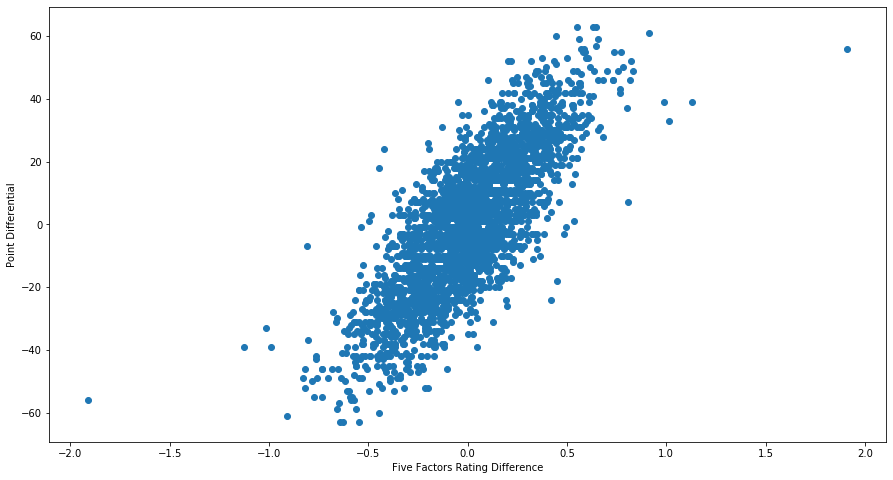

In [10]:
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(15,8))
ax.scatter(stored_game_boxes['5FRDiff'], stored_game_boxes.PtsDiff);
ax.set_xlabel("Five Factors Rating Difference")
ax.set_ylabel("Point Differential");

In [11]:
# Eliminate outliers
# basis = stored_game_boxes[stored_game_boxes['5FRDiff'] != 0]
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes['PtsDiff']))
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3) | (stored_game_boxes['pts_z_score'] >= 3)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3) & (stored_game_boxes['pts_z_score'] < 3)]
msk = np.random.rand(len(basis)) < 0.80
train_data = basis[msk]
test_data = basis[~msk]

In [12]:
outliers

,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,Akron,0,-52,0.000004,0.258065,0.000000,2.532258,25.846154,0.000000,0.000000,0.076923,0.750000,0.71,0.00,0.205361,-0.821485,3.025619,2.386745
1,Penn State,52,52,0.999996,0.508772,0.228070,7.754386,36.272727,4.727273,0.666667,0.818182,0.562500,0.71,0.00,1.026846,0.821485,3.025619,2.386745
0,Hawai'i,23,-33,0.000019,0.506329,0.075949,6.468354,23.000000,2.300000,0.428571,0.700000,0.525424,0.71,0.00,0.531732,-1.014284,3.735717,1.514665
1,UCLA,56,33,0.999981,0.620000,0.320000,10.160000,27.375000,7.000000,1.000000,0.875000,0.681818,0.71,0.00,1.546016,1.014284,3.735717,1.514665
0,Georgia State,0,-56,0.000008,0.317460,0.095238,4.285714,21.500000,0.000000,0.500000,0.333333,0.400000,0.71,0.22,0.344652,-1.912062,7.042331,2.570341
1,Penn State,56,56,0.999992,0.714286,0.428571,12.000000,61.000000,11.200000,0.000000,0.800000,0.000000,0.49,-0.22,2.256714,1.912062,7.042331,2.570341
0,Kent State,3,-39,0.000005,0.250000,0.017857,2.392857,30.333333,0.250000,0.333333,0.250000,0.333333,1.42,0.22,0.257016,-0.989483,3.644374,1.790059
1,Louisville,42,39,0.999995,0.600000,0.280000,9.580000,19.750000,5.250000,0.714286,0.875000,0.608696,1.20,-0.22,1.246499,0.989483,3.644374,1.790059
0,Florida Atlantic,14,-49,0.000007,0.343284,0.074627,4.462687,28.000000,1.272727,0.666667,0.272727,0.454545,0.22,0.22,0.429105,-0.831494,3.062482,2.249048
1,Oklahoma,63,49,0.999993,0.561404,0.245614,10.035088,28.800000,6.300000,0.777778,0.900000,0.592593,0.00,-0.22,1.260599,0.831494,3.062482,2.249048


In [13]:
train_data.head()

,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,Oregon State,27,-31,0.001059,0.422535,0.084507,5.323944,29.166667,2.250000,0.571429,0.583333,0.460000,1.59,0.66,0.577936,-0.231237,0.851670,1.422867
1,Colorado State,58,31,0.998941,0.560000,0.120000,6.333333,40.100000,5.800000,1.000000,0.900000,0.577465,0.93,-0.66,0.809173,0.231237,0.851670,1.422867
0,Hawai'i,38,3,0.678120,0.403226,0.096774,6.258065,54.250000,4.750000,0.500000,1.000000,0.403226,1.64,0.44,0.781945,0.098849,0.364070,0.137697
0,South Florida,42,20,0.964204,0.467391,0.076087,4.858696,25.117647,2.470588,0.800000,0.294118,0.686275,1.10,-1.32,0.397204,-0.156706,0.577164,0.917979
1,San José State,22,-20,0.035796,0.287671,0.082192,4.657534,30.714286,1.571429,0.750000,0.285714,0.346154,2.42,1.32,0.553910,0.156706,0.577164,0.917979


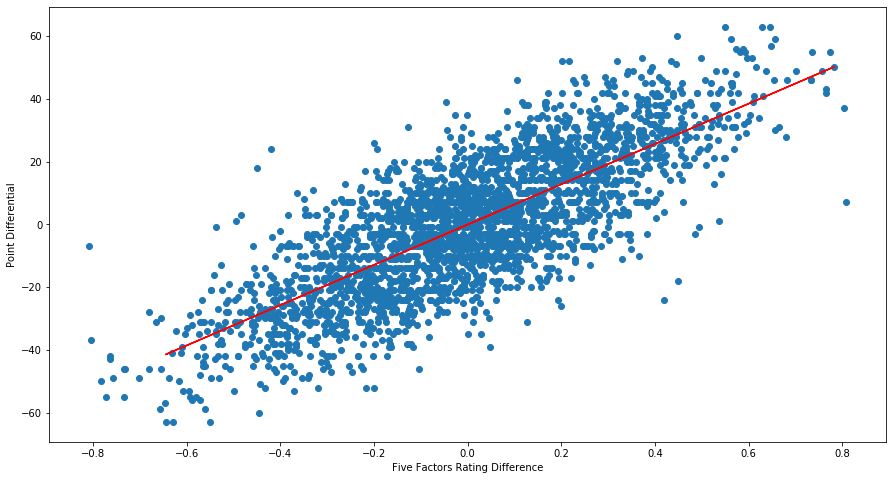

In [14]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

f, ax = plt.subplots(figsize=(15,8))
ax.scatter(basis['5FRDiff'], basis.PtsDiff)
ax.set_xlabel("Five Factors Rating Difference")
ax.set_ylabel("Point Differential")

xfit = test_data['5FRDiff']
yfit = model.predict(xfit[:, np.newaxis])
ax.plot(xfit, yfit, color='red', label='Linear Regression');

In [15]:
print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

Linear Regression: y = 64.20892x + -0.05289


In [30]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = yfit.mean()
    std = yfit.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {stringify_entry(max_box_row.PtsDiff)}")
    print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    print("")
    proj_point_diff = model.coef_[0] * stringify_entry(max_box_row['5FRDiff']) + model.intercept_
    print(f"Proj MOV by 5FRDiff: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * stats.norm.cdf(z)):.2f}%")

In [31]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)

Actual Winner: Virginia Tech
MOV: Virginia Tech by 3
5FRDiff for Virginia Tech: -0.011872886502929725

Proj MOV by 5FRDiff: Virginia Tech by -1.0 (exact value: -0.8152305584869342)
Z score: -0.0795469387346623
Win Prob for Virginia Tech: 46.83%


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [32]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA

Could not find basic game data for game_id 401112488 locally, checking CFB Data API
Could not find drive data for game_id 401112488 locally, checking CFB Data API
Could not find play by play data for game_id 401112488 locally, checking CFB Data API
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7
5FRDiff for Georgia Tech: 0.022578461300923447

Proj MOV by 5FRDiff: Georgia Tech by 1.0 (exact value: 1.396853311459941)
Z score: 0.059845432245291985
Win Prob for Georgia Tech: 52.39%


In [33]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT

Could not find basic game data for game_id 401112513 locally, checking CFB Data API
Could not find drive data for game_id 401112513 locally, checking CFB Data API
Could not find play by play data for game_id 401112513 locally, checking CFB Data API
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2
5FRDiff for Georgia Tech: -0.26760689803959825

Proj MOV by 5FRDiff: Georgia Tech by -17.0 (exact value: -17.23563550571521)
Z score: -1.1142632119924614
Win Prob for Georgia Tech: 13.26%


In [34]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST

Could not find basic game data for game_id 401110863 locally, checking CFB Data API
Could not find drive data for game_id 401110863 locally, checking CFB Data API
Could not find play by play data for game_id 401110863 locally, checking CFB Data API
Actual Winner: Mississippi State
MOV: Mississippi State by 1
5FRDiff for Mississippi State: -0.11066913311081772

Proj MOV by 5FRDiff: Mississippi State by -7.0 (exact value: -7.158830953364946)
Z score: -0.47928291240398624
Win Prob for Mississippi State: 31.59%


In [35]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU

Actual Winner: Texas A&M
MOV: Texas A&M by 2
5FRDiff for Texas A&M: -0.07251913741311644

Proj MOV by 5FRDiff: Texas A&M by -5.0 (exact value: -4.70926089294516)
Z score: -0.3249255739493534
Win Prob for Texas A&M: 37.26%


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
